# Train resnet18 operator on mnist dataset.

In [1]:
import sys
sys.path.append('..')
import torch
import matplotlib.pyplot as plt
import random
from resnet_image_embedding import ResnetImageEmbedding
from towhee.trainer.training_config import TrainingConfig
from torchvision import transforms
from towhee import dataset
from torchvision.transforms import Lambda

# build a resnet op with 10 classes output, because the mnist has 10 classes:
op = ResnetImageEmbedding('resnet18', num_classes=10)

In [2]:
# build a training config:
training_config = TrainingConfig()
training_config.batch_size = 64
training_config.epoch_num = 2
training_config.tensorboard = None
training_config.output_dir = 'mnist_output'

In [3]:
# prepare the mnist data
mean = 0.1307
std = 0.3081
mnist_transform = transforms.Compose([transforms.ToTensor(),
                                          Lambda(lambda x: x.repeat(3, 1, 1)),
                                          transforms.Normalize(mean=[mean] * 3, std=[std] * 3)])
train_data = dataset('mnist', transform=mnist_transform, download=True, root='data', train=True)
eval_data = dataset('mnist', transform=mnist_transform, download=True, root='data', train=False)

In [4]:
# start to train mnist, it will take about 30-100 minutes on a cpu machine.
# if you train on a gpu machine, it will be much faster.
op.train(training_config, train_dataset=train_data, eval_dataset=eval_data)

2022-03-02 18:43:32,380 - 8612169216 - trainer.py-trainer:390 - WARNING: TrainingConfig(output_dir='mnist_output', overwrite_output_dir=True, eval_strategy='epoch', eval_steps=None, batch_size=64, val_batch_size=-1, seed=42, epoch_num=2, dataloader_pin_memory=True, dataloader_drop_last=True, dataloader_num_workers=0, lr=5e-05, metric='Accuracy', print_steps=None, load_best_model_at_end=False, early_stopping={'monitor': 'eval_epoch_metric', 'patience': 4, 'mode': 'max'}, model_checkpoint={'every_n_epoch': 1}, tensorboard=None, loss='CrossEntropyLoss', optimizer='Adam', lr_scheduler_type='linear', warmup_ratio=0.0, warmup_steps=0, device_str=None, n_gpu=-1, sync_bn=False, freeze_bn=False)
[epoch 1/2] loss=0.203, metric=0.945, eval_loss=0.182, eval_metric=0.988: 100%|██████████| 937/937 [19:04<00:00,  1.22s/step]
[epoch 2/2] loss=0.044, metric=0.994, eval_loss=0.045, eval_metric=0.989: 100%|██████████| 937/937 [19:08<00:00,  1.20s/step]

### If you observe loss is decreasing and metric is increasing, it means you are training the model correctly.
### After finishing training, we can use this model to do predict.

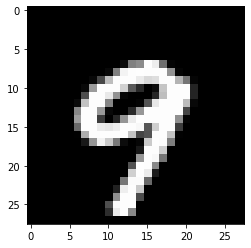

this picture is number 9


In [12]:
# get random picture and predict it.
img_index = random.randint(0, len(eval_data))
img = eval_data.dataset[img_index][0]
img = img.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
pil_img = img * std + mean
plt.imshow(pil_img)
plt.show()
test_img = eval_data.dataset[img_index][0].unsqueeze(0).to(op.trainer.configs.device)
out = op.trainer.predict(test_img)
predict_num = torch.argmax(torch.softmax(out, dim=-1)).item()
print('this picture is number {}'.format(predict_num))

### You can repeat running this prediction code cell multiple times and check if the prediction result is right.